In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is available and configured:", gpus)
    except RuntimeError as e:
        print("❌ RuntimeError:", e)
else:
    print("❌ No GPU detected by TensorFlow")



✅ GPU is available and configured: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


Example 1 - Image shape: (256, 256, 3)
Example 1 - Label =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Example 1 - Mask shape: (256, 256, 1)


Example 2 - Image shape: (256, 256, 3)
Example 2 - Label =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Example 2 - Mask shape: (256, 256, 1)




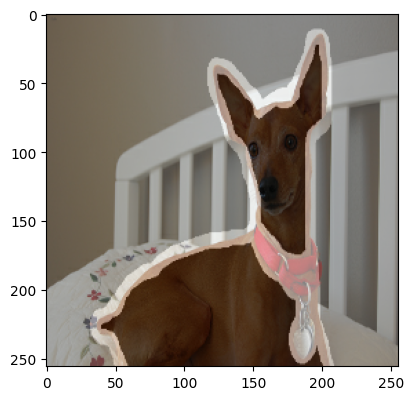

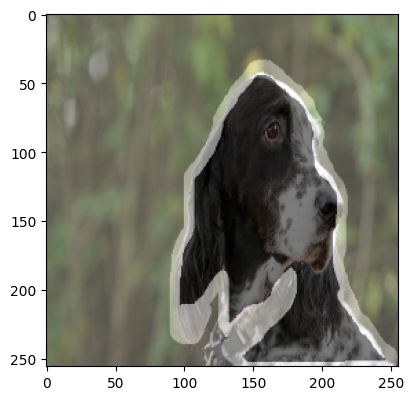

In [3]:
from data_loading import OxfordPetDataset
from augmentation import random_flip, augmentation_layers_geometric, augmentation_layers_color
from models import UNet_model #2.a, 2.b exercises
from experiment import plot_results

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

print("\n")

for i, example in enumerate(train.take(2)):  # Take two examples
    print(f"Example {i+1} - Image shape:", example['image'].shape)
    image = example['image']
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    label = example['label']
    print(f"Example {i+1} - Label = ", label.numpy())
    mask = example['segmentation_mask']  # This is the segmentation mask
    plt.imshow(mask, cmap='gray', alpha=0.5)
    print(f"Example {i+1} - Mask shape:", mask.numpy().shape)
    print("\n")
plt.show()

In [4]:
train

<MapDataset element_spec={'image': TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(37,), dtype=tf.float32, name=None), 'segmentation_mask': TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)}>

In [5]:
augmentation_color = augmentation_layers_color()
augmentation_geometric = augmentation_layers_geometric()

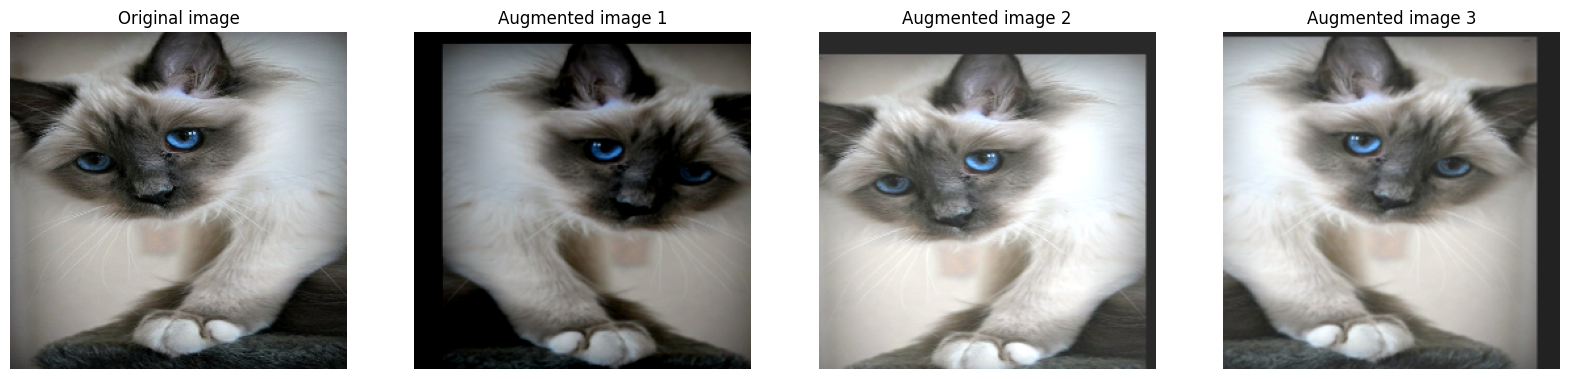

In [6]:
for example in train.take(1):
    image = example['image']
    
    plt.figure(figsize=(20, 5))
    
    # Plot original image
    plt.subplot(1, 4, 1)
    plt.title("Original image")
    plt.imshow(image)
    plt.axis("off")
    
    # Plot augmented images
    for i in range(3):
        aug_img = augmentation_geometric(tf.expand_dims(image, axis=0))
        aug_img = augmentation_color(aug_img)
        plt.subplot(1, 4, i+2)
        plt.title(f"Augmented image {i+1}")
        plt.imshow(aug_img[0])
        plt.axis("off")

plt.show()

From now on we want all datasets to be lists of just images and masks

In [7]:
def extract_image_mask(data):
    """Extract image and mask from dictionary"""
    return data['image'], data['segmentation_mask']

# Apply to all datasets
train = train.map(extract_image_mask)
val = val.map(extract_image_mask)
test = test.map(extract_image_mask)

In [8]:
def augment_image_mask(image, mask):
    # Add batch dimension (from (H,W,C) to (1,H,W,C)
    batched_image = tf.expand_dims(image, axis=0)
    batched_mask = tf.expand_dims(mask, axis=0)
    
    # Apply color augmentation to image only
    aug_image = augmentation_color(batched_image, training=True)
    
    # Combine image+mask for geometric augmentations
    combined = tf.concat([aug_image, batched_mask], axis=-1)
    combined = augmentation_geometric(combined, training=True)
    
    # Split back and remove batch dimension
    aug_image, aug_mask = tf.split(combined, [3, tf.shape(batched_mask)[-1]], axis=-1)
    return tf.squeeze(aug_image, axis=0), tf.squeeze(aug_mask, axis=0)

# Apply augmentations to training data only
train = train.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
BATCH_SIZE = 32
EPOCHS = 50

# Batch the data and use prefetching to optimize loading speed
train_ds = train.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
'''# for my low spec pc
# Define testing parameters
TEST_SAMPLE_SIZE = 20  # Use 100 samples per dataset
BATCH_SIZE = 4          # Reduced for low-spec PCs
EPOCHS = 3

# Load and limit datasets
train_ds = train.take(TEST_SAMPLE_SIZE).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val.take(TEST_SAMPLE_SIZE).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test.take(TEST_SAMPLE_SIZE).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
'''

In [22]:
# Initialize and compile model
model = UNet_model(input_shape=reshape_size + (3,))
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callback to save the best model
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [23]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0654 - loss: 1.0124
Epoch 1: val_loss improved from inf to 0.12491, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 9s/step - accuracy: 0.0704 - loss: 1.2769 - val_accuracy: 0.0000e+00 - val_loss: 0.1249
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0871 - loss: 0.2064
Epoch 2: val_loss did not improve from 0.12491
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.0901 - loss: 0.2216 - val_accuracy: 0.0000e+00 - val_loss: 0.4383
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0871 - loss: 0.4573
Epoch 3: val_loss improved from 0.12491 to 0.08565, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.0901 - loss: 0.4528 - val_accuracy: 0.0000e+00 - val_loss: 0.0856


In [24]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on validation set (optional but confirms performance)
val_loss, val_accuracy = best_model.evaluate(val_ds)
print(f"\nBest Model Validation Metrics:")
print(f"Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"\nBest Model Test Metrics:")
print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.0000e+00 - loss: 0.0902

Best Model Validation Metrics:
Loss: 0.0856, Accuracy: 0.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.0000e+00 - loss: 0.0790

Best Model Test Metrics:
Loss: 0.0784, Accuracy: 0.0000
